## 1. Import Libraries

In [434]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

You’ll learn how to preprocess Time Series, build a simple LSTM model, train it, and use it to make predictions

The steps we follow in this exercise are:
 - TIME SERIES
 - Recurrent Neural networks
 Time series prediction with LSTMs

## What is time series data?

- Collection of data points based on the time they were collected
- Recorded at regular time intervals


### What are the applications?

- Forcasting future time series value
- The price of something tomorrow, for eg.bitcoins
- Number of sales during a given season of the year
- Future heart faliure

#### Proterties time series can have?
- **Stationarity:** when the mean and the variance remain constant over time. If the mean is varying over time, then it means time series has got a **trend**. You can avoid that, by log tranformations.
- **Seasonality:** If there are variations at specific time-frame. Eliminate that using differencing method.Differencing is a type of tranformation, that accomplishes:
  - Making a time series stationary
  - Stabilizing the mean of the time series
- **Autocorrelation:** Refers to the correlation between the currrent value with a copy from previous time.

## Method we are using

 The two most commonly used gated RNNs are Long Short-Term Memory Networks and Gated Recurrent Unit Neural Networks.

Read for more information: https://en.wikipedia.org/wiki/Recurrent_neural_network

## Generate the 1000 value from sine function and use that as training data

In [435]:
time = np.arange(0, 100, 0.1)
## Add noise to the data, by adding random value to each data point, the random value is drawn from a normal distribution
sin  = np.sin(time) + np.random.normal(scale=0.5, size=len(time))


800 200


## Visualize the data

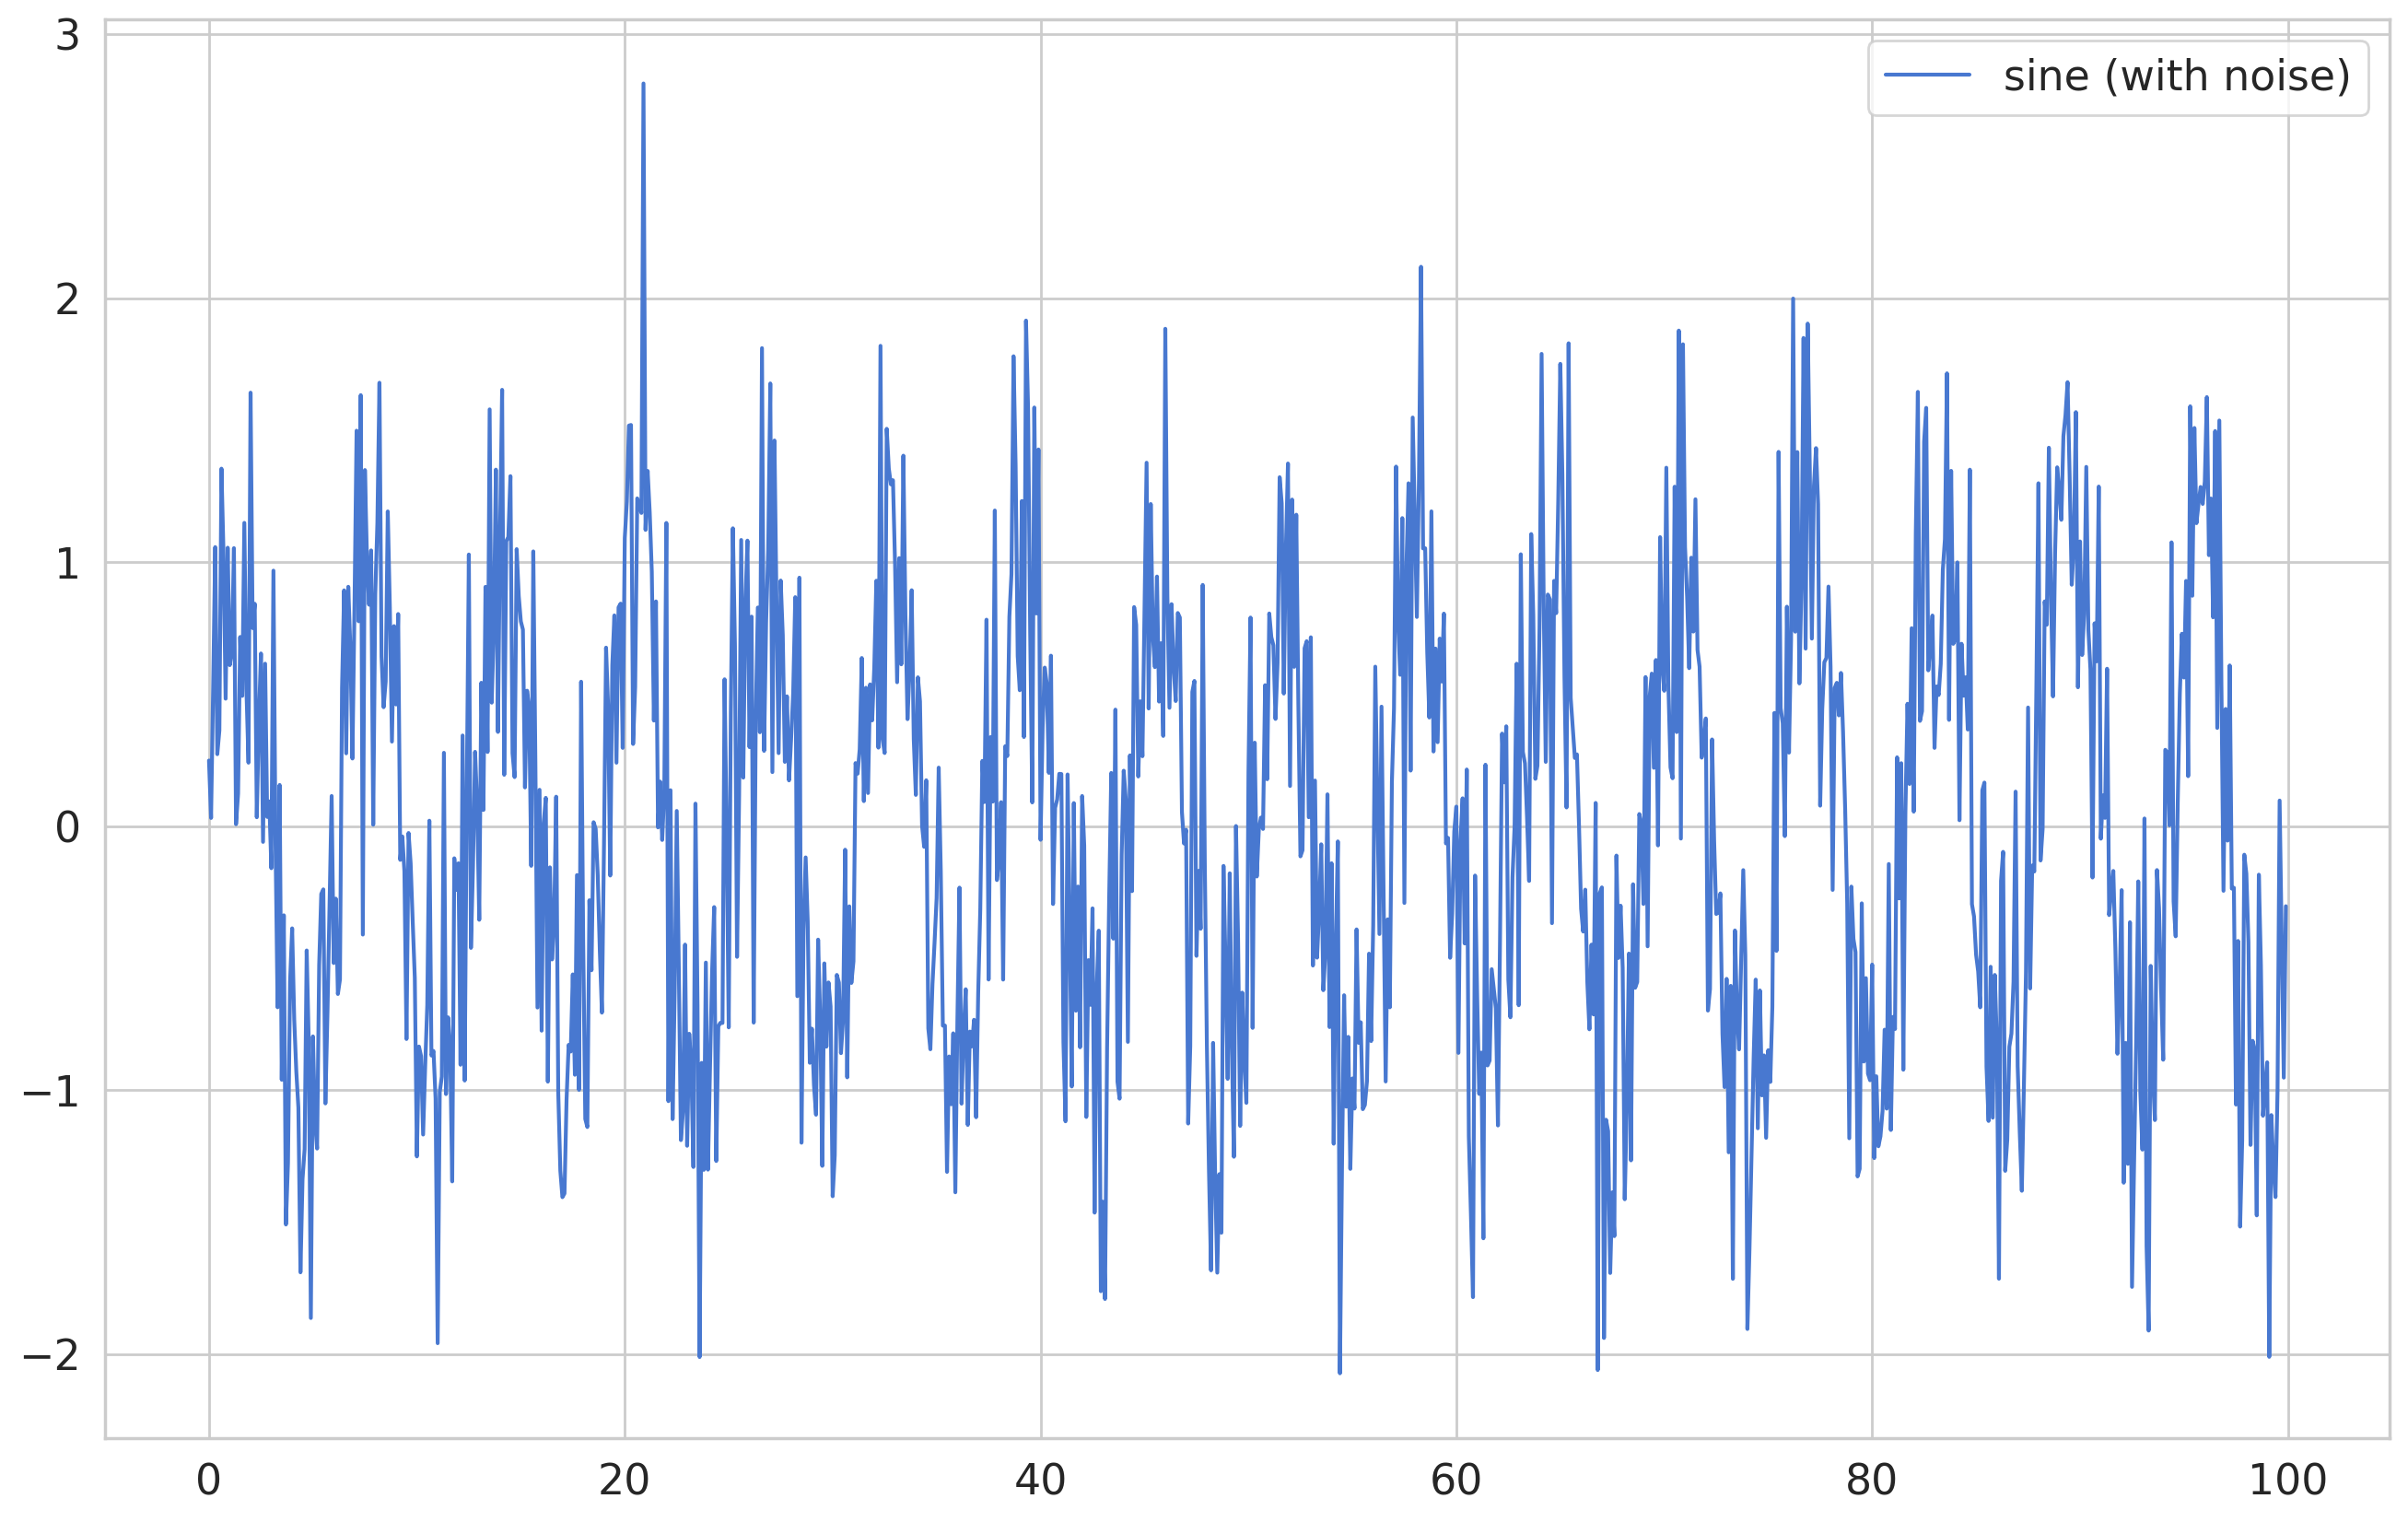

In [436]:
plt.plot(time, sin, label='sine (with noise)');
plt.legend();

In [438]:
## Data preprocessing

In [439]:
df   = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
df.head()

,sine
0.0,0.248357
0.1,0.030701
0.2,0.522514
0.3,1.057035
0.4,0.272342


- “chop the data” into smaller sequences for our model
- But first, we’ll split it into training and test data

In [440]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


Getting the data ready for Time Series prediction, specifically using LSTMs, can be a challenging task.
- The basic idea is to forecast the value at the current time step based on the historical data (i.e., data from n time steps prior). 
- To achieve this, a generic function can be used.

In [185]:
def create_dataset(X, y, time_steps=1):
    """
    Works with single features(univariate) and multiple features
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [442]:
# History of 10 time steps to make the sequences
time_steps = 10

In [443]:

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)
print(X_train.shape, y_train.shape)

(790, 10, 1) (790,)


## Modelling

- Train in Keras
- lstm layers are used in sequential model to make the predictions

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(units=1))
model.compile( loss='mean_squared_error',optimizer=keras.optimizers.Adam(0.001))

- LSTM expects the number of time steps and number of features

## Train

In [446]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30
45/45 [==============================] - 3s 19ms/step - loss: 0.3735 - val_loss: 0.3454
Epoch 2/30
45/45 [==============================] - 0s 10ms/step - loss: 0.3225 - val_loss: 0.3191
Epoch 3/30
45/45 [==============================] - 0s 10ms/step - loss: 0.3179 - val_loss: 0.3176
Epoch 4/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3172 - val_loss: 0.3157
Epoch 5/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3164 - val_loss: 0.3143
Epoch 6/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3157 - val_loss: 0.3131
Epoch 7/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3151 - val_loss: 0.3118
Epoch 8/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3143 - val_loss: 0.3105
Epoch 9/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3135 - val_loss: 0.3092
Epoch 10/30
45/45 [==============================] - 0s 9ms/step - loss: 0.3127 - val_loss: 0.3082
Epoch 11/30
45/4

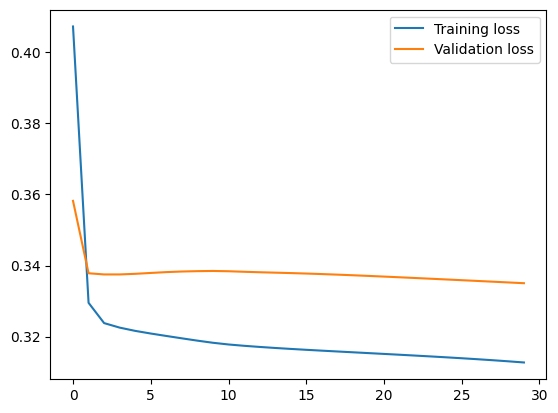

In [189]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

- Our dataset is pretty simple and contains the randomness from our sampling
- After about 15 epochs, the model is pretty much-done learning. 

## Evaluation

In [448]:
y_pred = model.predict(X_test)
     

6/6 [==============================] - 0s 5ms/step


## Plot the predictions over true values from the time series

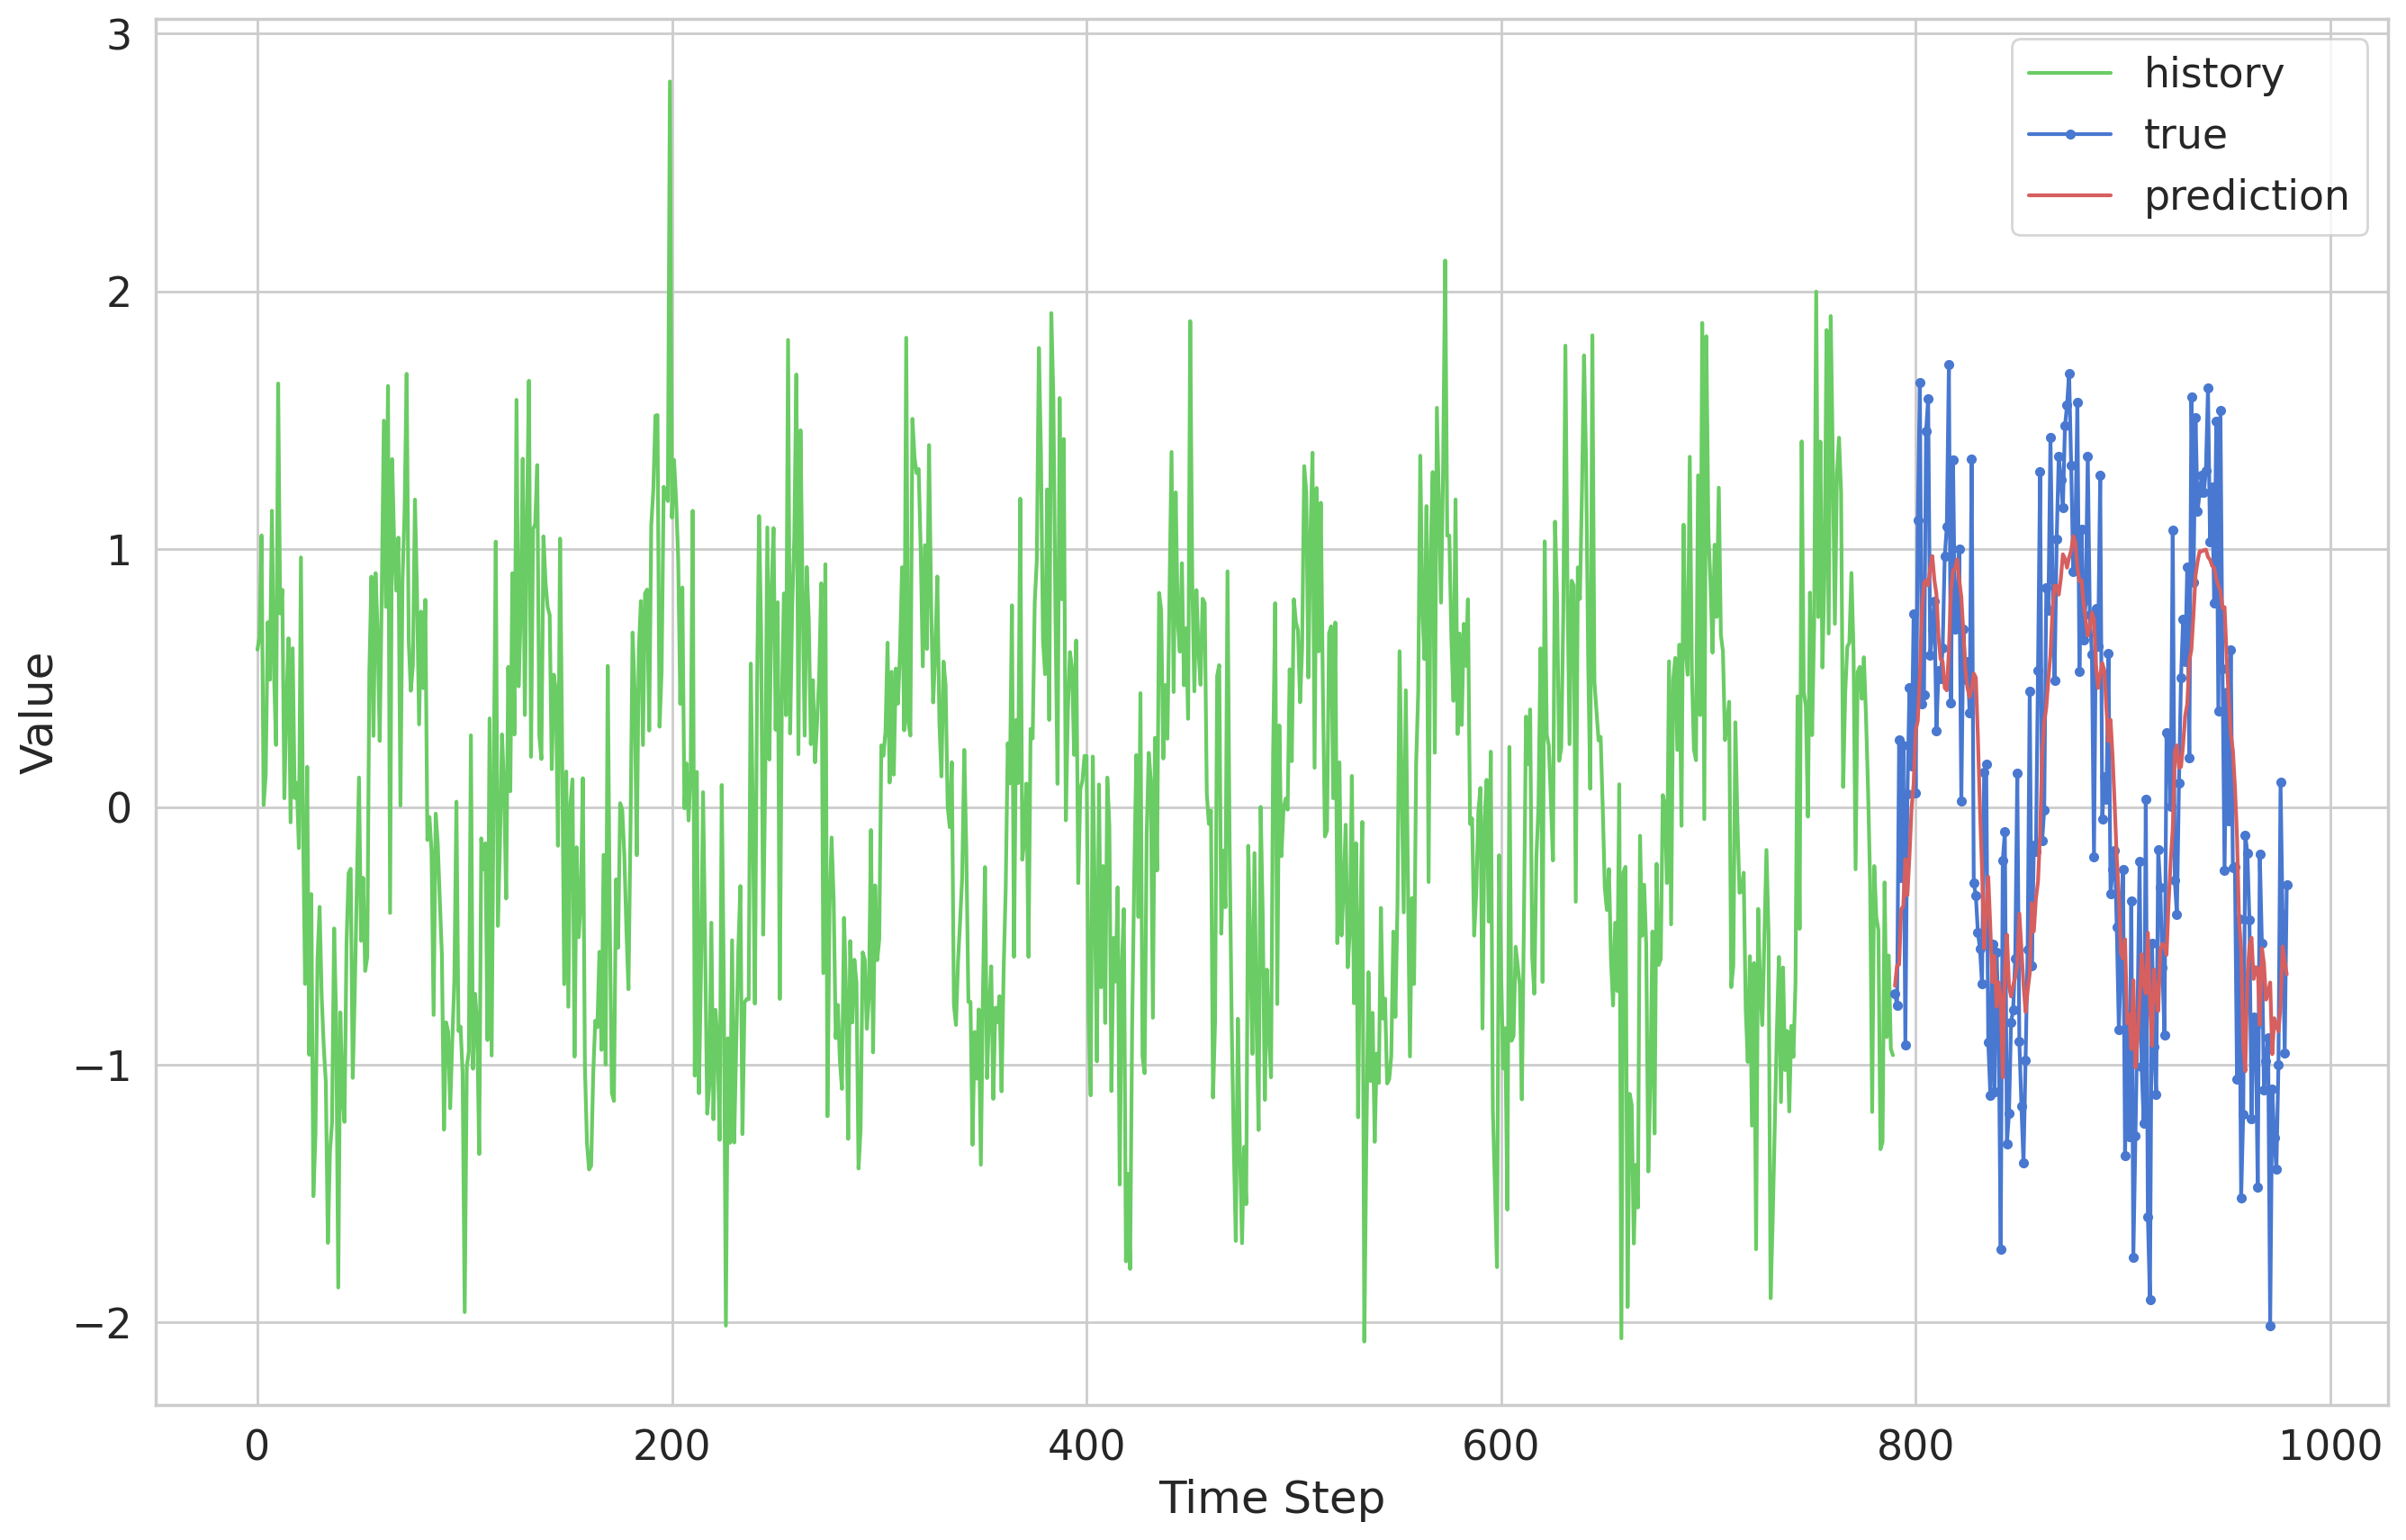

In [449]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Looks good. Lets Zoom in

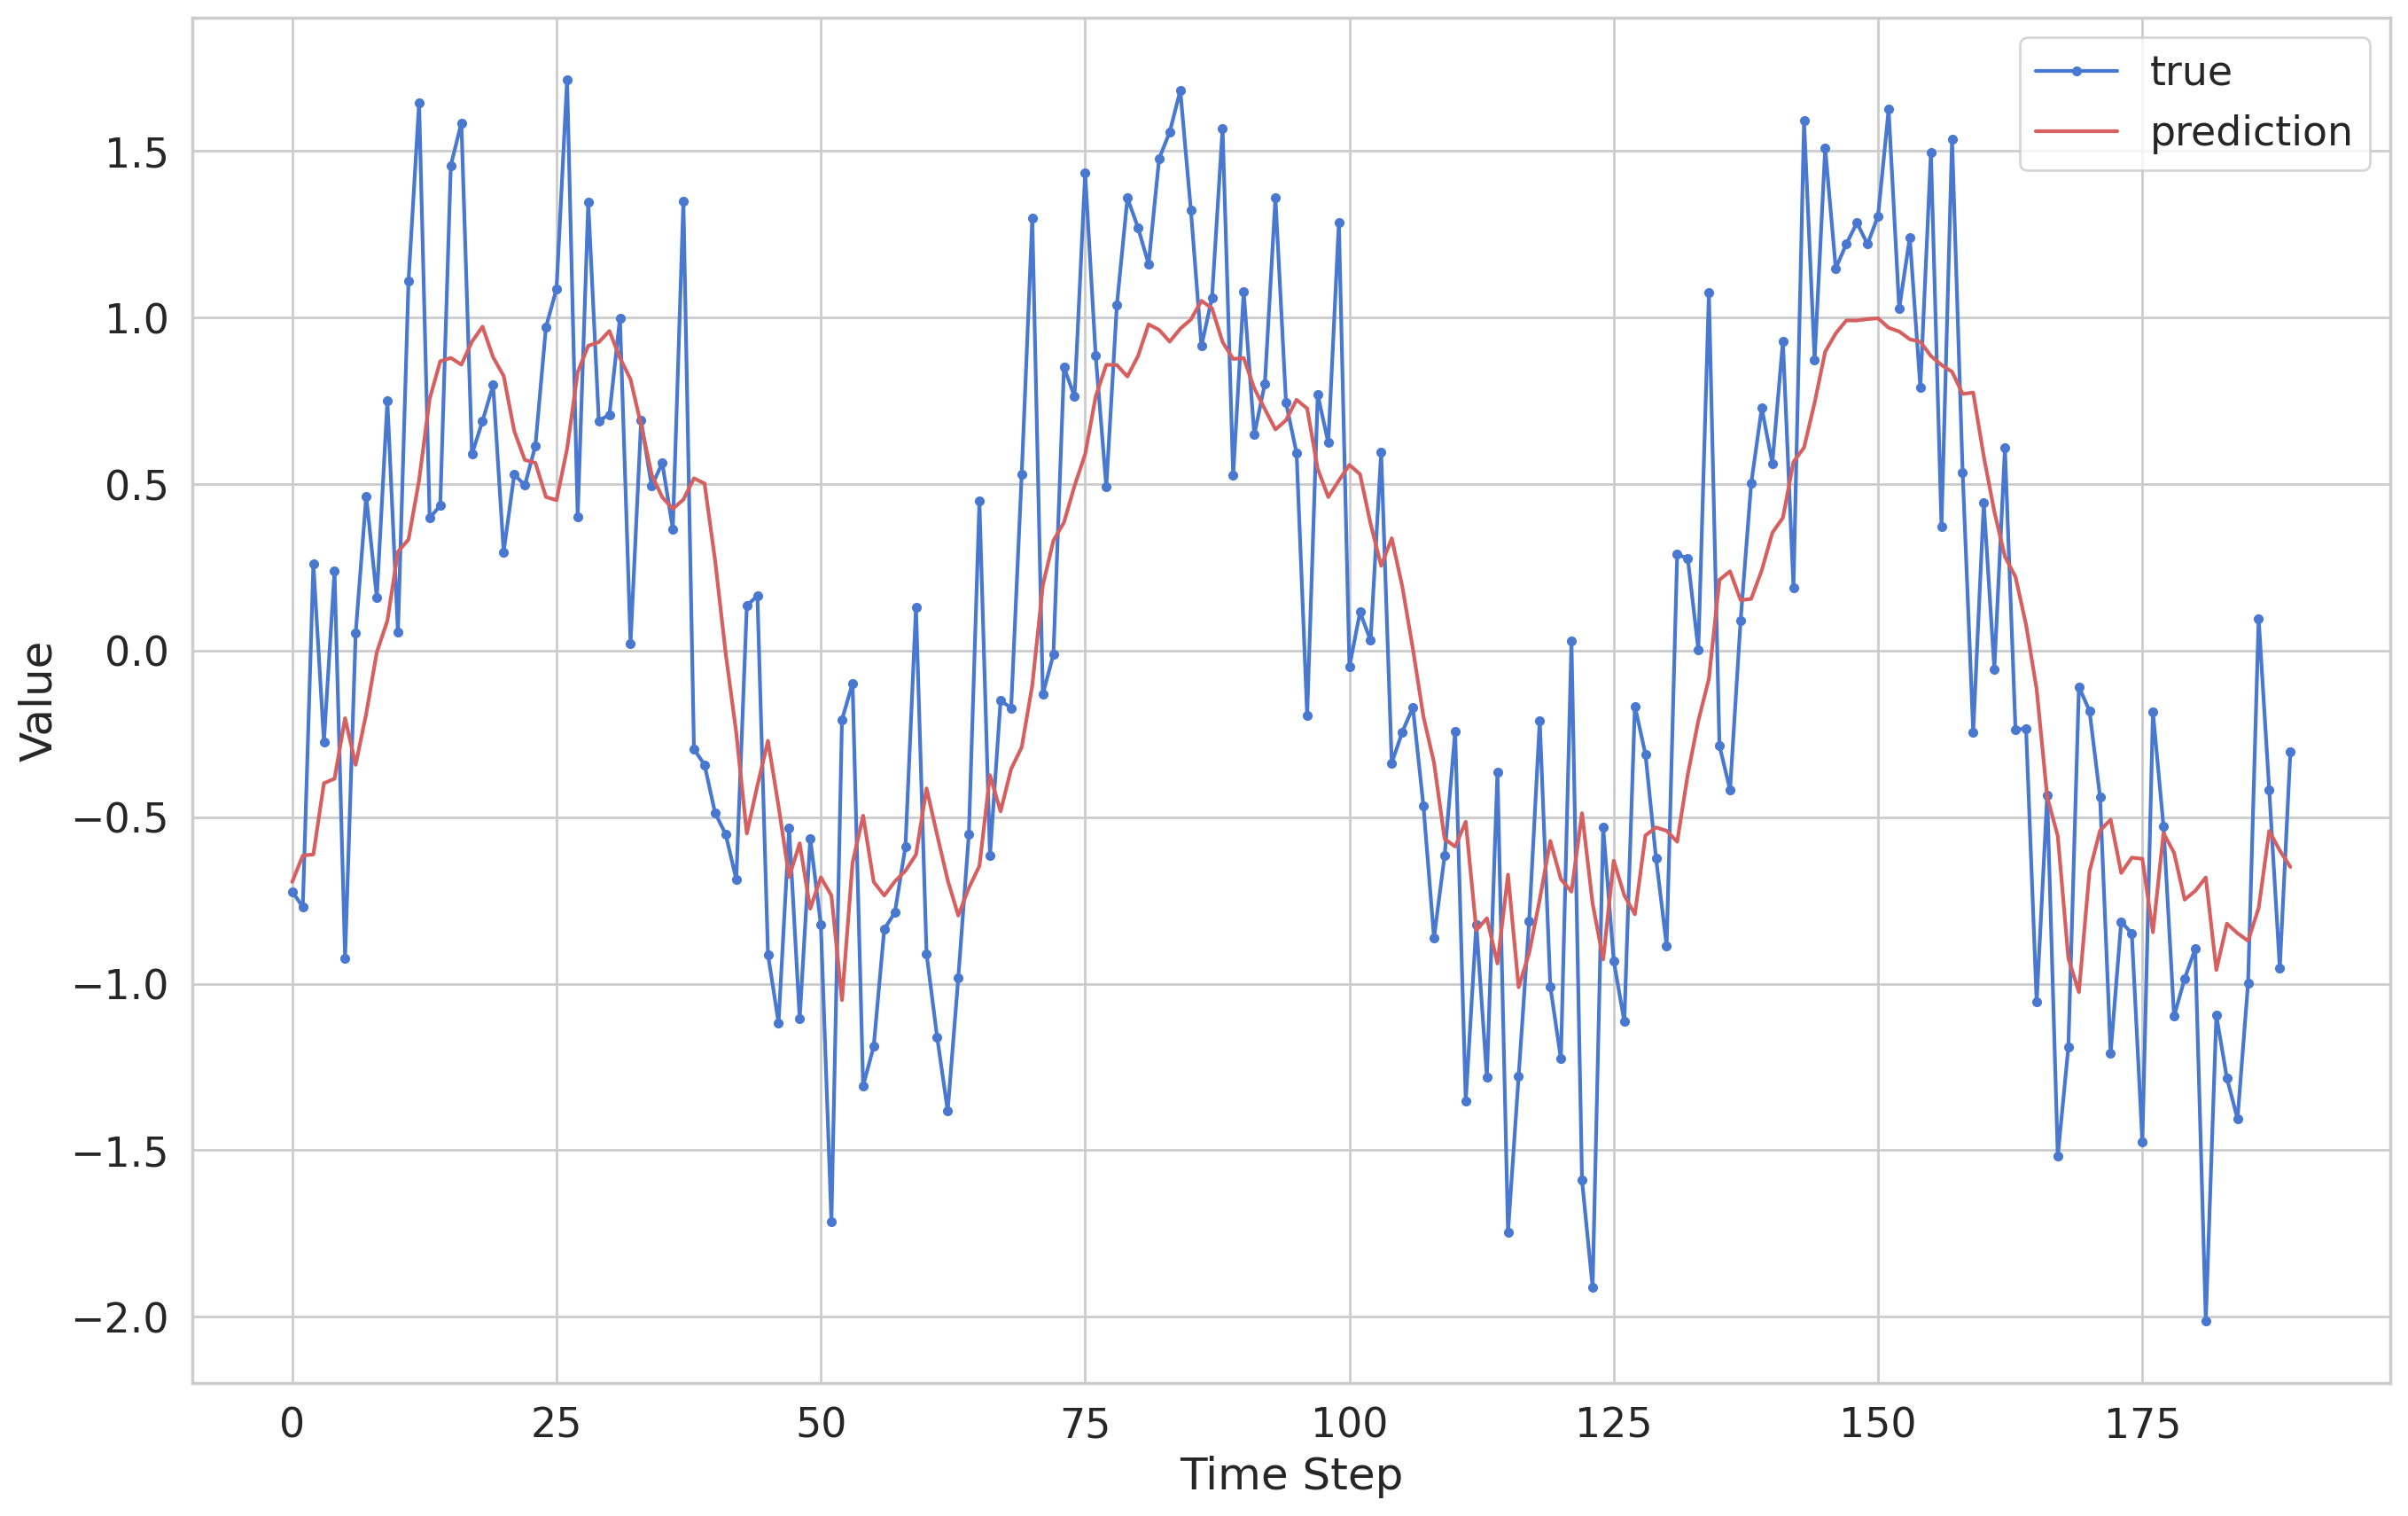

In [450]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Interpretaions

The model appears to be doing a great job of capturing the general pattern of the data 
- Since, it failed to capture the random flucations, we can say the model generalizes well

# Conclusion

We learned preprocessing time series data, learned about the time series data, Using the LSTM to predict the time series